In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from datetime import datetime
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import GOES
import xarray as xr
import datetime as datetime
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timezone   
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin
import optuna
from sklearn.model_selection import train_test_split
import os
import shutil
from datetime import datetime, timedelta


2024-11-05 22:21:44.114024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 22:21:44.124039: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 22:21:44.223238: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 22:21:44.329558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 22:21:44.425248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Imagemodel: Este modelo se utiliza para extraer las caracteristicas de las que contienen las etiquetas de tipos de nubes, (4 etiquetas en total).  VGG16 es un algoritmo de clasificación y detección utilizado para clasificar 1000 imagenes de 1000 diferentes categorías con un 92.7% de presición.

In [2]:
# Función para graficar un rango de muestras definido por el usuario
def graficar_rango_muestras(best_actual_vs_pred, inicio, fin):
    # Asegurarse de que los índices de inicio y fin estén dentro del rango válido
    inicio = max(0, inicio)
    fin = min(fin, len(best_actual_vs_pred))

    if inicio >= fin:
        print("El índice de inicio debe ser menor que el índice de fin.")
        return

    # Crear la gráfica para el rango de muestras
    plt.figure(figsize=(10, 6))
    plt.plot(best_actual_vs_pred['Valores Reales'][inicio:fin], label='Valores Reales')
    plt.plot(best_actual_vs_pred['Predicciones'][inicio:fin], label='Predicciones', linestyle='--')

    # Ajustar el título y etiquetas
    plt.title(f'Valores Reales vs Predicciones (Muestras desde {inicio} hasta {fin})')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.legend()

    # Mostrar la gráfica
    plt.show()

In [3]:
class ImageModel(tf.keras.Model):
    """
    Clase que contiene el modelo de redes convolucionales  encargada de extraer carácterísticas esenciales de las imagenes, en este caso
    el producto del ABI que contiene la probabilidad de existencia de nubosidad.
    
    Base_model = VGG16(...) Red neuronal preentrenada con 1000 iamgenes que contienen 1000 diferentes categorías.
    Args:
        1. weights = imagenet: el modelo se inicializará con los pesos aprendidos al entrenar VGG16 en el conjunto de datos de imagenet,
        una base de 1000 diferentes categorías. Util para clasificar bordes, texturas, formas.
        2. Include_top=False: Se exluye la ultima capa la cual contiene 1000 neuronas utilizadas para clasificar de acuerdo con el dataset
        de imagenes contenido en el dataset de imagenet. Solo se usa este modelo para extraer patrones e información importante.
        3. Input_shape = (300, 300, 3): Por rendimiento, logré utilizar imagenes de resolución de 300x300 con 3 canales referidos al RGB.
    
    Extracción de características:self.feature_extractor = Model(..)
    extraer la salida de la red neuronal y transformarla en un vector unidimensional.
    Args:
        1. inputs=base_model.input: entrada de la red convolucional VGG16.
        2. outputs=Flatten()(base_model.output): Salida de la red convolusional. Función flatten() para convertir en unidimencsional.
    
    Definición del flujo de datos: def call(...), se usa para llamar al modelo. En este caso cree el modelo base_model y lo llamo con el
    parámetro inputs, que serán las imagenes.
    return self.feature_extractor(inputs): la entrada son la imagenes y retorna el vector unitario con las características.
    """
    def __init__(self):
        super(ImageModel, self).__init__()
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
        self.feature_extractor = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))
    
    def call(self, inputs):
        # Extraer las características de las imágenes
        return self.feature_extractor(inputs)


class NumericalModel(tf.keras.Model):
    """
    Esta clase contiene un modelo para entrenas datos numéricos.
        1. tf.keras.sequential(): Las capas iran conectadas de manera secuencial.
        2. tf.keras.layers.Dense(128, activation='relu'): Capa totalmente conectada con 128 neuronas con función de activación
        Relu.
        3. tf.keras.layers.Dense(64, activation='relu'): Capa totalmente conectada con 64 neuronas con función de activación
        Relu.
    Definición del flujo de datos: def call(...): al igual que el anterior, se recibe una secuencia de datos numericos y se 
    retorna la salida de la red neuronal.
    """
    def __init__(self, num_units_numeric=128, num_hidden_layers=2, activation='relu'):
        super(NumericalModel, self).__init__()
        layers = []

        # Crear las capas ocultas dinámicamente
        for i in range(num_hidden_layers):
            layers.append(tf.keras.layers.Dense(num_units_numeric, activation=activation))
            # Reducir el tamaño de las unidades en cada capa
            num_units_numeric = int(num_units_numeric)

        self.fc = tf.keras.Sequential(layers)

    def call(self, inputs):
        return self.fc(inputs)

class CombinedModel(tf.keras.Model):
    """
    Objetivo: Combinar las salidas de los modelos anteriores para procesarlas de manera conjunta. Muy aspero!!
        1. self.image_model = ImageModel(...): En esta linea, llamamos la clase que contiene el modelo que procesa las imagenes. Ojo, recibe
        las imagenes y retorna el vector de 1 variable.
        2. self.numerical_model = NumericalModel(): Recibe los datos numéricos y extrae las características.

    self.fc = tf.keras.Sequential(...): Capda densa, totalmente conectada de manera secuencial por donde se pasarán lo datos combinados.
        1. tf.keras.layers.Dense(256, activation='relu'): Capa densa totalmente conectada de 256 neuronas con función de activacióN Relu.
        2. tf.keras.layers.Dense(1). Capa de salida, 1 porque es un vector numérico.

    Definición de flujo de datos:
        Se reciben los dastos numéricos y las imagenes. 
        1. image_features = self.image_model(image_inputs): Pasamos la lista de imagenes a traves del modelo VGG16.
        2. numerical_features = self.numerical_model(numerical_inputs): Pasamos la lista de números a traves del modelo numérico.
        3. combined = tf.concat([image_features, numerical_features], axis=1): Combinamos las salidas de los modelos y hacemos haga de cuenta un
        vector gigante.
        4. self.fc(combined): La entrada de la capa densa son el vector de una dimensión con todos los datos y la salida es el valor de regresión,
        utilizo (1) para predecir un valor numérico.
    """  
    def __init__(self, num_units_numeric=128, num_hidden_layers=2, activation='relu',dropout_rate=0.0):
        super(CombinedModel, self).__init__()
        self.image_model = ImageModel()
        self.numerical_model = NumericalModel(num_units_numeric=num_units_numeric, 
                                              num_hidden_layers=num_hidden_layers, 
                                              activation=activation)
        
        # Capa final para la regresión
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(num_units_numeric, activation=activation),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1)  # Capa de salida para la predicción
        ])
    
    def call(self, inputs):
        image_inputs, numerical_inputs = inputs
        image_features = self.image_model(image_inputs)
        numerical_features = self.numerical_model(numerical_inputs)
        combined = tf.concat([image_features, numerical_features], axis=1)
        return self.fc(combined)


In [4]:

def build_combined_model(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    num_units_numeric = trial.suggest_int("num_units_numeric", 32, 256)
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    batch_size = trial.suggest_int("batch_size", 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
    
    model = CombinedModel(num_units_numeric=num_units_numeric, 
                          num_hidden_layers=num_hidden_layers, 
                          activation=activation,dropout_rate=dropout_rate)
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model, batch_size


In [5]:
carpeta_resultado = '/home/aia-workstation/Documents/modelo_xray/metricas_modelo'

if not os.path.exists(carpeta_resultado):
    os.makedirs(carpeta_resultado)
    print(f'Carpeta creada: {carpeta_resultado}')
else:
    print(f'La carpeta ya existe: {carpeta_resultado}')



La carpeta ya existe: /home/aia-workstation/Documents/modelo_xray/metricas_modelo


In [6]:
# Resolución y 3 por RGB
height, width, channels = 64, 64, 3 

In [7]:
# Obtener el número total de imágenes
direccion = '/media/aia-workstation/193fc329-d8a2-46ef-9387-b9b6a758aeab/images_oneyear/images_oneyear'
 
carpeta_destino = '/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2'
carpeta_resultados = 'carpeta_resultados'

carpetas_seleccionadas = ['enero','febrero','marzo']
image_files = []

for folder in carpetas_seleccionadas:
    image_folder = os.path.join(direccion,folder)
    image_folder = os.path.normpath(image_folder)
    print("dirección carpeta:",image_folder)
    if os.path.exists(image_folder):
        image_files += sorted([os.path.join(image_folder, i) for i in os.listdir(image_folder) if i.endswith('.png')])
    else:
        print("carpeta inexistente")

print(f"Número total de archivos de imagen: {len(image_files)}")

dirección carpeta: /media/aia-workstation/193fc329-d8a2-46ef-9387-b9b6a758aeab/images_oneyear/images_oneyear/enero
dirección carpeta: /media/aia-workstation/193fc329-d8a2-46ef-9387-b9b6a758aeab/images_oneyear/images_oneyear/febrero
dirección carpeta: /media/aia-workstation/193fc329-d8a2-46ef-9387-b9b6a758aeab/images_oneyear/images_oneyear/marzo
Número total de archivos de imagen: 12952


In [8]:
import os
import shutil
from datetime import datetime, timedelta

# Mapeo de los nombres de los meses en inglés a español en minúsculas
meses_esp = {
    'january': 'enero',
    'february': 'febrero',
    'march': 'marzo',
    'april': 'abril',
    'may': 'mayo',
    'june': 'junio',
    'july': 'julio',
    'august': 'agosto',
    'september': 'septiembre',
    'october': 'octubre',
    'november': 'noviembre',
    'december': 'diciembre'
}

def generar_meses_rango(fecha_inicio, fecha_fin):
    """Genera una lista de nombres de meses (en español y minúsculas) entre dos fechas."""
    meses = []
    mes_actual = fecha_inicio

    while mes_actual <= fecha_fin:
        mes_nombre_ingles = mes_actual.strftime('%B').lower()  # Nombre del mes en inglés
        mes_nombre_esp = meses_esp[mes_nombre_ingles]  # Convertir a español
        if mes_nombre_esp not in meses:
            meses.append(mes_nombre_esp)
        # Avanzar al siguiente mes
        mes_actual += timedelta(days=32)
        mes_actual = mes_actual.replace(day=1)  # Saltar al primer día del próximo mes
    
    return meses

def procesar_imagenes_por_intervalo_seis_meses(direccion, carpeta_destino, fecha_inicio_str, fecha_fin_str, hora_inicio_str='05:00', hora_fin_str='18:40'):
    # Convertir las fechas de entrada a objetos datetime
    fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y%m%d')
    fecha_fin = datetime.strptime(fecha_fin_str, '%Y%m%d')
    hora_inicio = datetime.strptime(hora_inicio_str, '%H:%M').time()
    hora_fin = datetime.strptime(hora_fin_str, '%H:%M').time()
    
    # Generar los meses que corresponden al rango de fechas proporcionado
    carpetas_seleccionadas = generar_meses_rango(fecha_inicio, fecha_fin)
    imagenes_filtradas = []
    fechas_procesadas = set()  # Conjunto para almacenar fechas ya procesadas

    print(f"Procesando imágenes de los meses: {carpetas_seleccionadas}")
    
    # Verificar si la carpeta destino existe, si no, crearla
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
        print(f'Carpeta creada: {carpeta_destino}')
    
    # Recorrer las carpetas seleccionadas y procesar las imágenes
    for folder in carpetas_seleccionadas:
        image_folder = os.path.join(direccion, folder)
        image_folder = os.path.normpath(image_folder)
        
        if os.path.exists(image_folder):
            # Obtener todas las imágenes en la carpeta
            image_files = sorted([os.path.join(image_folder, i) for i in os.listdir(image_folder) if i.endswith('.png')])
            
            for image_path in sorted(image_files):
                nombre_imagen = os.path.basename(image_path)
                # Extraer la fecha y hora directamente después de `_s`
                try:
                    fecha_hora_str = nombre_imagen.split('_s')[1][:14]
                    fecha_hora = datetime.strptime(fecha_hora_str, '%Y%m%d%H%M%S')
                except (ValueError, IndexError):
                    print(f"Formato de fecha no coincide para {nombre_imagen}, se omitirá.")
                    continue
                
                # Verificar si la fecha y hora están en el rango
                if fecha_inicio.date() <= fecha_hora.date() <= fecha_fin.date() and hora_inicio <= fecha_hora.time() <= hora_fin:
                    fecha_solo = fecha_hora.strftime('%Y%m%d%H%M')  # Solo la fecha y hora
                    
                    # Copiar solo una imagen por cada fecha y hora única
                    if fecha_solo not in fechas_procesadas:
                        nuevo_nombre = f"{fecha_solo}.png"  # Renombrar como solo fecha y hora
                        ruta_destino = os.path.join(carpeta_destino, nuevo_nombre)
                        
                        shutil.copy(image_path, ruta_destino)
                        print(f'Imagen copiada: {nombre_imagen} -> {nuevo_nombre}')
                        imagenes_filtradas.append((ruta_destino, fecha_hora))
                        
                        fechas_procesadas.add(fecha_solo)  # Marcar esta fecha como procesada
        else:
            print(f"La carpeta {folder} no existe")

    print(f"Número total de imágenes únicas copiadas a {carpeta_destino}: {len(imagenes_filtradas)}")
    return imagenes_filtradas



In [9]:
# Ejemplo de uso
direccion = '/media/aia-workstation/193fc329-d8a2-46ef-9387-b9b6a758aeab/images_oneyear/images_oneyear'
carpeta_destino = '/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2'

fecha_inicio_str = '20230101'  
fecha_fin_str = '20230401'   

# Llamar a la función para procesar imágenes desde enero hasta junio
imagenes_filtradas = procesar_imagenes_por_intervalo_seis_meses(direccion, carpeta_destino, fecha_inicio_str, fecha_fin_str)

Procesando imágenes de los meses: ['enero', 'febrero', 'marzo', 'abril']
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230107110022.png -> 202301071100.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230107110522.png -> 202301071105.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230121111022.png -> 202301211110.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230121111522.png -> 202301211115.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101050020.png -> 202301010500.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101051020.png -> 202301010510.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101052020.png -> 202301010520.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101053020.png -> 202301010530.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101054020.png -> 202301010540.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101055020.png -> 202301010550.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101060020.png -> 202301010600.png
Imagen copiada: OR_ABI-L2-ACMF-M6_G16_s20230101061020.png -> 20230101

In [10]:
import importlib
import intervalos_faltantes

importlib.reload(intervalos_faltantes)

direccion = '/media/aia-workstation/193fc329-d8a2-46ef-9387-b9b6a758aeab/images_oneyear/images_oneyear'
carpeta_destino = '/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2'

fecha_inicio_str2 = fecha_inicio_str+'-'+'000000'  
fecha_fin_str2 = fecha_fin_str + '-'+'000000'  

imagenes_faltantes, intervalos_esperados, timestamps_archivos ,imagenes_faltantez, repetidas = intervalos_faltantes.buscar_imagenes_faltantes(carpeta_destino, fecha_inicio_str2, fecha_fin_str2)


print("Imágenes faltantes (formateadas):", imagenes_faltantes)
print("Lista de imágenes reptidas:", repetidas)



intervalos: ['202301010500', '202301010510', '202301010520', '202301010530', '202301010540', '202301010550', '202301010600', '202301010610', '202301010620', '202301010630', '202301010640', '202301010650', '202301010700', '202301010710', '202301010720', '202301010730', '202301010740', '202301010750', '202301010800', '202301010810', '202301010820', '202301010830', '202301010840', '202301010850', '202301010900', '202301010910', '202301010920', '202301010930', '202301010940', '202301010950', '202301011000', '202301011010', '202301011020', '202301011030', '202301011040', '202301011050', '202301011100', '202301011110', '202301011120', '202301011130', '202301011140', '202301011150', '202301011200', '202301011210', '202301011220', '202301011230', '202301011240', '202301011250', '202301011300', '202301011310', '202301011320', '202301011330', '202301011340', '202301011350', '202301011400', '202301011410', '202301011420', '202301011430', '202301011440', '202301011450', '202301011500', '2023010115

In [11]:
"""
Procesamiento de datos numércos:
Utilizaré el las variables GHI como mi vairable a la salida y DoY Sin'&'DoY Cos' para intentar predecir la irradiancia, puedo tener 
la misma irradiancia en la mañana y en la tarde.
"""


# Asegurar que 't_filtrar' está en df después de filtrar por fecha y hora
df = pd.read_csv('DatosParaCompartir.csv')
df['t'] = pd.to_datetime(df['t'], utc=True)
df.set_index('t', inplace=True)

# Definir rango de fechas
inicio = datetime.strptime(fecha_inicio_str + '0500', '%Y%m%d%H%M').replace(tzinfo=timezone.utc)
fin = datetime.strptime(fecha_fin_str + '1830', '%Y%m%d%H%M').replace(tzinfo=timezone.utc)

# Aplicar filtros de fecha y hora
df = df[(df.index >= inicio) & (df.index <= fin)]
df = df[(df.index.time >= pd.to_datetime('05:00:00').time()) & (df.index.time <= pd.to_datetime('18:30:00').time())]

# Crear o recrear 't_filtrar' después de aplicar los filtros
df['t_filtrar'] = df.index.strftime('%Y%m%d%H%M')
quitar_fechas = imagenes_faltantez
fechas_imagenes = sorted(timestamps_archivos)

# Verificar si 't_filtrar' está en el DataFrame y proceder con el filtro
if 't_filtrar' in df.columns:
    # Convertir listas a conjuntos para una comparación más sencilla
    fechas_imagenes_set = set(fechas_imagenes)
    fechas_excel_set = set(df['t_filtrar'].tolist())

    # Identificar fechas que están en Excel pero no en las imágenes y viceversa
    faltantes_en_imagenes = fechas_excel_set - fechas_imagenes_set
    faltantes_en_excel = fechas_imagenes_set - fechas_excel_set

    if fechas_excel_set != fechas_imagenes_set:
        print("Las fechas no están alineadas. Se procederá a filtrar las fechas que faltan en imágenes.")
        print("Fechas que están en Excel pero no en imágenes:", faltantes_en_imagenes)
        print("Cantidad de Fechas que están en Excel pero no en imágenes:", len(faltantes_en_imagenes))
        print("Fechas que están en imágenes pero no en Excel:", faltantes_en_excel)
        
        # Filtrar el DataFrame para excluir las fechas en `quitar_fechas`
        df = df[~df['t_filtrar'].isin(quitar_fechas)]
        
    else:
        print("Las fechas en el archivo Excel y las imágenes están alineadas y en el mismo orden.")
else:
    print("La columna 't_filtrar' no está en el DataFrame después de aplicar los filtros.")


# Recorrer todas las imágenes en el directorio
for filename in os.listdir(carpeta_destino):
    # Verificar si el nombre de archivo contiene una de las fechas a eliminar
    for fecha in faltantes_en_excel:
        if fecha in filename:
            ruta_imagen = os.path.join(carpeta_destino, filename)
            os.remove(ruta_imagen)  # Eliminar la imagen
            print(f"Imagen eliminada: {ruta_imagen}")
            
print("Número de filas después de filtrar:", len(df))

scaler = MinMaxScaler()

columnas = ['GHI','TempAmb','Wind Y','Wind X','DoY Sin','DoY Cos']
escalizar = ['GHI','TempAmb','Wind Y','Wind X']
df[escalizar] = scaler.fit_transform(df[escalizar])
df = df[columnas].reset_index()

df = df[columnas]
df.head()


df.head()

Las fechas no están alineadas. Se procederá a filtrar las fechas que faltan en imágenes.
Fechas que están en Excel pero no en imágenes: {'202302091240', '202303081620', '202303081640', '202303201710', '202303201740', '202303201700', '202303081630', '202303181110', '202303041710', '202302181600', '202303051710', '202303031710', '202303081650', '202303201540', '202302041600', '202303041600', '202303061710', '202303081700'}
Cantidad de Fechas que están en Excel pero no en imágenes: 18
Fechas que están en imágenes pero no en Excel: {'202306051450', '202305190510', '202304061000', '202304061740', '202305271350', '202305190700', '202305191500', '202303181115', '202306151140', '202305251240', '202304230850', '202304021510', '202306090710', '202306131040', '202305251040', '202306241010', '202306260730', '202304271520', '202305031410', '202306231610', '202305060740', '202305101550', '202306040500', '202305121000', '202305300820', '202306131720', '202304270930', '202305151120', '202306091320', '

GHI   TempAmb    Wind Y    Wind X   DoY Sin   DoY Cos
0  0.0  0.162259  0.333559  0.625983  0.017166  0.999853
1  0.0  0.158944  0.405713  0.547815  0.017166  0.999853
2  0.0  0.156459  0.356250  0.599419  0.017166  0.999853
3  0.0  0.154896  0.393574  0.550754  0.017166  0.999853
4  0.0  0.150641  0.411174  0.555939  0.017166  0.999853

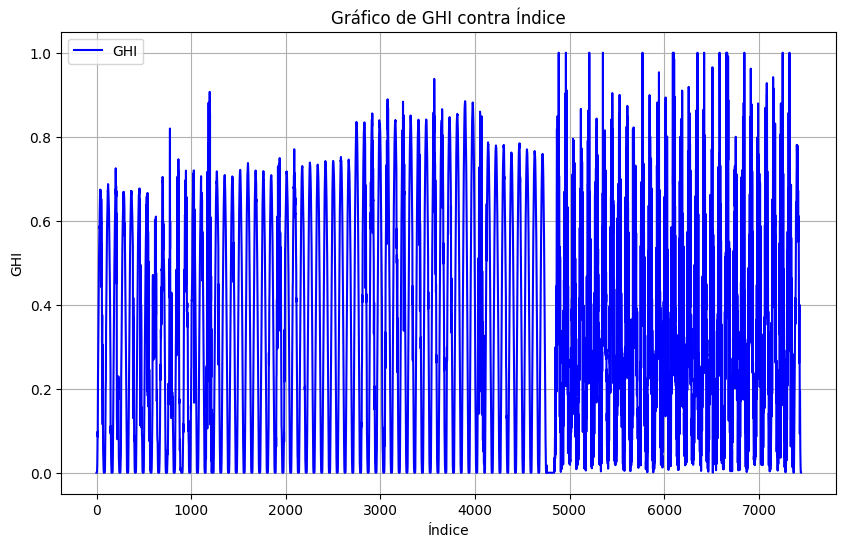

In [13]:

# Supongamos que 'df' es tu DataFrame y 'Valores' es la columna que deseas graficar contra el índice
def graficar_df(df, columna):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[columna], label=columna, color='blue')
    plt.xlabel("Índice")
    plt.ylabel(columna)
    plt.title(f"Gráfico de {columna} contra Índice")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llama a la función con tu DataFrame y la columna deseada
# Por ejemplo, si 'df_resultados' es tu DataFrame:
graficar_df(df, columna='GHI')


In [14]:
# Creo las variables numericas y mi variable de salida para el modelo.
numericas = ['TempAmb','Wind Y','Wind X','DoY Sin','DoY Cos']
valores_numericos = df[numericas].values
salida = ['GHI']
y = df[salida].values



print(type(valores_numericos))  
print(valores_numericos.shape)  


<class 'numpy.ndarray'>
(7444, 5)


In [15]:
print(type(y))  
print(y.shape)  


<class 'numpy.ndarray'>
(7444, 1)


In [16]:
# Crear una nueva lista sin las fechas que están en faltantes_en_excel
imagenes_filtradas_filtradas = [
    (ruta, fecha) for ruta, fecha in imagenes_filtradas 
    if fecha.strftime('%Y%m%d%H%M') not in faltantes_en_excel
]

# Mostrar la lista filtrada
print("Imágenes después de eliminar las fechas en faltantes_en_excel:")
print(imagenes_filtradas_filtradas)


Imágenes después de eliminar las fechas en faltantes_en_excel:
[('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301071100.png', datetime.datetime(2023, 1, 7, 11, 0, 22)), ('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301211110.png', datetime.datetime(2023, 1, 21, 11, 10, 22)), ('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301010500.png', datetime.datetime(2023, 1, 1, 5, 0, 20)), ('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301010510.png', datetime.datetime(2023, 1, 1, 5, 10, 20)), ('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301010520.png', datetime.datetime(2023, 1, 1, 5, 20, 20)), ('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301010530.png', datetime.datetime(2023, 1, 1, 5, 30, 20)), ('/home/aia-workstation/Documents/modelo_xray/carpeta_resultados2/202301010540.png', datetime.datetime(2023, 1, 1, 5, 40, 20)), ('/home/aia-workstation/Documents/model

In [17]:
def load_and_preprocess_image(image_path, target_size=(height, width)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32')
    return image



In [19]:
image_tensors  = []

for ruta_destino, fecha_hora in imagenes_filtradas_filtradas:
    image_tensor = load_and_preprocess_image(ruta_destino, target_size=(64,64))
    image_tensors.append(image_tensor)

tensor_images = np.array(image_tensors)
print(f"Formato de tensor_images: {tensor_images.shape}")

Formato de tensor_images: (7444, 64, 64, 3)


In [20]:
# Verificar el número de muestras en imágenes, datos numéricos y etiquetas

print(f"Tamaño de valores_numericos: {valores_numericos.shape}")  # (492, 3)
print(f"Tamaño de y: {y.shape}")  # (492, 1)
print(f"Tamaño de y: {tensor_images.shape}") 

# Asegúrate de que todos tienen el mismo número de muestras (492)
if valores_numericos.shape[0] == y.shape[0] == tensor_images.shape[0]:
    print("El número de muestras coincide en todas las entradas.")
else:
    print("El número de muestras no coincide.")


Tamaño de valores_numericos: (7444, 5)
Tamaño de y: (7444, 1)
Tamaño de y: (7444, 64, 64, 3)
El número de muestras coincide en todas las entradas.


In [21]:
# Dividir el conjunto de datos en tres partes: entrenamiento, validación y prueba/predicción
X_train_images, X_temp_images, X_train_numerical, X_temp_numerical, y_train, y_temp = train_test_split(
    tensor_images, valores_numericos, y, test_size=0.4, shuffle=False
)

# Luego dividir el conjunto temporal en validación y prueba/predicción
X_val_images, X_test_images, X_val_numerical, X_test_numerical, y_val, y_test = train_test_split(
    X_temp_images, X_temp_numerical, y_temp, test_size=0.5, shuffle=False
)


[I 2024-11-05 22:35:26,887] A new study created in memory with name: no-name-cb19530d-3739-41b9-958a-97e012f264d8


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


[I 2024-11-05 22:47:26,425] Trial 0 finished with value: 0.039188579652897494 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 70, 'num_hidden_layers': 3, 'learning_rate': 0.0003636502349639089, 'batch_size': 51, 'dropout_rate': 0.37869856213347075}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


[I 2024-11-05 22:59:51,757] Trial 1 finished with value: 0.23242401287796643 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'num_units_numeric': 67, 'num_hidden_layers': 1, 'learning_rate': 1.821224263857542e-05, 'batch_size': 29, 'dropout_rate': 0.37725502551862633}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


[I 2024-11-05 23:12:17,559] Trial 2 finished with value: 0.041219665221931164 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'num_units_numeric': 39, 'num_hidden_layers': 1, 'learning_rate': 0.00041767477439726467, 'batch_size': 27, 'dropout_rate': 0.21496228808758966}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step


[I 2024-11-05 23:24:12,921] Trial 3 finished with value: 0.08948553175012523 and parameters: {'optimizer': 'rmsprop', 'activation': 'tanh', 'num_units_numeric': 208, 'num_hidden_layers': 3, 'learning_rate': 8.8990691653459e-05, 'batch_size': 55, 'dropout_rate': 0.2607905528595005}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


[I 2024-11-05 23:36:01,102] Trial 4 finished with value: 0.08520781767417727 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'num_units_numeric': 123, 'num_hidden_layers': 1, 'learning_rate': 3.174754606721003e-05, 'batch_size': 57, 'dropout_rate': 0.38569474392200664}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


[I 2024-11-05 23:48:15,546] Trial 5 finished with value: 0.07478926428385994 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'num_units_numeric': 209, 'num_hidden_layers': 1, 'learning_rate': 2.577275924218888e-05, 'batch_size': 39, 'dropout_rate': 0.254506351895669}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


[I 2024-11-06 00:00:09,375] Trial 6 finished with value: 0.08797733507683529 and parameters: {'optimizer': 'rmsprop', 'activation': 'tanh', 'num_units_numeric': 245, 'num_hidden_layers': 1, 'learning_rate': 2.9095967493011302e-05, 'batch_size': 48, 'dropout_rate': 0.1805549046214443}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


[I 2024-11-06 00:11:42,986] Trial 7 finished with value: 0.08753959383805494 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'num_units_numeric': 64, 'num_hidden_layers': 1, 'learning_rate': 4.217757482761637e-05, 'batch_size': 63, 'dropout_rate': 0.3284728026155035}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


[I 2024-11-06 00:24:22,870] Trial 8 finished with value: 0.08600486892071119 and parameters: {'optimizer': 'rmsprop', 'activation': 'tanh', 'num_units_numeric': 68, 'num_hidden_layers': 3, 'learning_rate': 0.00025960348840181754, 'batch_size': 21, 'dropout_rate': 0.23366225312875685}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


[I 2024-11-06 00:37:01,536] Trial 9 finished with value: 0.0871544482447198 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'num_units_numeric': 37, 'num_hidden_layers': 2, 'learning_rate': 8.637813070676544e-05, 'batch_size': 22, 'dropout_rate': 0.2339974190553922}. Best is trial 0 with value: 0.039188579652897494.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


[I 2024-11-06 00:49:11,313] Trial 10 finished with value: 0.034312837283972 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 135, 'num_hidden_layers': 2, 'learning_rate': 0.0009264562930375058, 'batch_size': 40, 'dropout_rate': 0.13260846704043616}. Best is trial 10 with value: 0.034312837283972.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


[I 2024-11-06 01:01:20,484] Trial 11 finished with value: 0.039842748782152874 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 126, 'num_hidden_layers': 2, 'learning_rate': 0.000915051716830856, 'batch_size': 42, 'dropout_rate': 0.10307441211619219}. Best is trial 10 with value: 0.034312837283972.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


[I 2024-11-06 01:13:29,042] Trial 12 finished with value: 0.035051356633819426 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 160, 'num_hidden_layers': 3, 'learning_rate': 0.0009394727722881464, 'batch_size': 42, 'dropout_rate': 0.10708064583549695}. Best is trial 10 with value: 0.034312837283972.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


[I 2024-11-06 01:25:40,365] Trial 13 finished with value: 0.03550349540095377 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 161, 'num_hidden_layers': 2, 'learning_rate': 0.0009912532525058516, 'batch_size': 37, 'dropout_rate': 0.10490359959507728}. Best is trial 10 with value: 0.034312837283972.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step


[I 2024-11-06 01:37:57,696] Trial 14 finished with value: 0.03301910671584161 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 159, 'num_hidden_layers': 3, 'learning_rate': 0.00020502512321969238, 'batch_size': 34, 'dropout_rate': 0.1574249310440385}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


[I 2024-11-06 01:50:07,637] Trial 15 finished with value: 0.03857071177689002 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 133, 'num_hidden_layers': 2, 'learning_rate': 0.00020927271607069003, 'batch_size': 30, 'dropout_rate': 0.1591055639338226}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


[I 2024-11-06 02:02:21,575] Trial 16 finished with value: 0.03740894408720625 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 182, 'num_hidden_layers': 2, 'learning_rate': 0.000487330713048867, 'batch_size': 34, 'dropout_rate': 0.14774247135149393}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


[I 2024-11-06 02:15:59,204] Trial 17 finished with value: 0.03481042048782542 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 89, 'num_hidden_layers': 3, 'learning_rate': 0.00014361636142160738, 'batch_size': 16, 'dropout_rate': 0.18775622729459557}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


[I 2024-11-06 02:27:58,278] Trial 18 finished with value: 0.05448381182132795 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 104, 'num_hidden_layers': 2, 'learning_rate': 6.133485484195271e-05, 'batch_size': 47, 'dropout_rate': 0.13832539667636978}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


[I 2024-11-06 02:40:11,257] Trial 19 finished with value: 0.07246090684973967 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 179, 'num_hidden_layers': 3, 'learning_rate': 1.2149782566619836e-05, 'batch_size': 34, 'dropout_rate': 0.2910832741472929}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


[I 2024-11-06 02:52:10,332] Trial 20 finished with value: 0.03573212823450291 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 256, 'num_hidden_layers': 2, 'learning_rate': 0.0005701832054399533, 'batch_size': 47, 'dropout_rate': 0.19577523522917134}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


[I 2024-11-06 03:04:31,881] Trial 21 finished with value: 0.0396637103729627 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 90, 'num_hidden_layers': 3, 'learning_rate': 0.00014512142203273608, 'batch_size': 24, 'dropout_rate': 0.176061984934561}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


[I 2024-11-06 03:18:06,016] Trial 22 finished with value: 0.03630009867465754 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 105, 'num_hidden_layers': 3, 'learning_rate': 0.00014913496529593968, 'batch_size': 16, 'dropout_rate': 0.13347381137863926}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


[I 2024-11-06 03:30:15,659] Trial 23 finished with value: 0.03688910315378737 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 151, 'num_hidden_layers': 3, 'learning_rate': 0.0002460324163452221, 'batch_size': 33, 'dropout_rate': 0.19946851031541243}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


[I 2024-11-06 03:43:37,602] Trial 24 finished with value: 0.03721333032577689 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 99, 'num_hidden_layers': 2, 'learning_rate': 0.00013563950631288897, 'batch_size': 17, 'dropout_rate': 0.164559354614969}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


[I 2024-11-06 03:55:46,728] Trial 25 finished with value: 0.058874943639834754 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 181, 'num_hidden_layers': 3, 'learning_rate': 5.507856347554405e-05, 'batch_size': 43, 'dropout_rate': 0.12851253782416258}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


[I 2024-11-06 04:08:01,372] Trial 26 finished with value: 0.035853465260788114 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 134, 'num_hidden_layers': 3, 'learning_rate': 0.0006512418086341223, 'batch_size': 37, 'dropout_rate': 0.196835148489552}. Best is trial 14 with value: 0.03301910671584161.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step


[I 2024-11-06 04:20:19,606] Trial 27 finished with value: 0.031666715884600766 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 87, 'num_hidden_layers': 2, 'learning_rate': 0.00030361320101743544, 'batch_size': 26, 'dropout_rate': 0.12696334450725646}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


[I 2024-11-06 04:32:44,327] Trial 28 finished with value: 0.034072275586227586 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 116, 'num_hidden_layers': 2, 'learning_rate': 0.0003269306225668398, 'batch_size': 26, 'dropout_rate': 0.12899863298283912}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step


[I 2024-11-06 04:45:11,858] Trial 29 finished with value: 0.03359030530445928 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 111, 'num_hidden_layers': 2, 'learning_rate': 0.00032709105738080584, 'batch_size': 25, 'dropout_rate': 0.12034679072126876}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step


[I 2024-11-06 04:57:59,762] Trial 30 finished with value: 0.03327108957211571 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 50, 'num_hidden_layers': 2, 'learning_rate': 0.00032455365608419185, 'batch_size': 21, 'dropout_rate': 0.15603461979235053}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


[I 2024-11-06 05:10:46,129] Trial 31 finished with value: 0.03868408112712017 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 82, 'num_hidden_layers': 2, 'learning_rate': 0.00035051750001158775, 'batch_size': 20, 'dropout_rate': 0.1567581207730826}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


[I 2024-11-06 05:22:58,549] Trial 32 finished with value: 0.031743170828322315 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 72, 'num_hidden_layers': 2, 'learning_rate': 0.000229076261495445, 'batch_size': 30, 'dropout_rate': 0.12126142933275758}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


[I 2024-11-06 05:35:06,239] Trial 33 finished with value: 0.055184613966113454 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 48, 'num_hidden_layers': 2, 'learning_rate': 0.00020010649510349363, 'batch_size': 30, 'dropout_rate': 0.16410205053139093}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


[I 2024-11-06 05:47:30,263] Trial 34 finished with value: 0.05550580965139592 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'num_units_numeric': 61, 'num_hidden_layers': 2, 'learning_rate': 0.0001089107000793397, 'batch_size': 29, 'dropout_rate': 0.2173620338163065}. Best is trial 27 with value: 0.031666715884600766.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


[I 2024-11-06 05:59:45,652] Trial 35 finished with value: 0.03045505290261648 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 51, 'num_hidden_layers': 2, 'learning_rate': 0.0001937490884336828, 'batch_size': 28, 'dropout_rate': 0.3542913045442204}. Best is trial 35 with value: 0.03045505290261648.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


[I 2024-11-06 06:11:58,352] Trial 36 finished with value: 0.03973529442109264 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'num_units_numeric': 78, 'num_hidden_layers': 1, 'learning_rate': 0.00018711634744255796, 'batch_size': 32, 'dropout_rate': 0.3498611357472335}. Best is trial 35 with value: 0.03045505290261648.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


[I 2024-11-06 06:24:14,785] Trial 37 finished with value: 0.039625431427440856 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 32, 'num_hidden_layers': 1, 'learning_rate': 0.00026705906201043833, 'batch_size': 27, 'dropout_rate': 0.3983598110376825}. Best is trial 35 with value: 0.03045505290261648.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


[I 2024-11-06 06:36:30,388] Trial 38 finished with value: 0.08774849235522038 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'num_units_numeric': 51, 'num_hidden_layers': 2, 'learning_rate': 9.743322832965256e-05, 'batch_size': 36, 'dropout_rate': 0.29610936841263175}. Best is trial 35 with value: 0.03045505290261648.


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


[I 2024-11-06 06:48:45,155] Trial 39 finished with value: 0.04071175243044898 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 200, 'num_hidden_layers': 2, 'learning_rate': 7.383722641678502e-05, 'batch_size': 31, 'dropout_rate': 0.3539652881634013}. Best is trial 35 with value: 0.03045505290261648.


Best hyperparameters:  {'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_numeric': 51, 'num_hidden_layers': 2, 'learning_rate': 0.0001937490884336828, 'batch_size': 28, 'dropout_rate': 0.3542913045442204}
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step


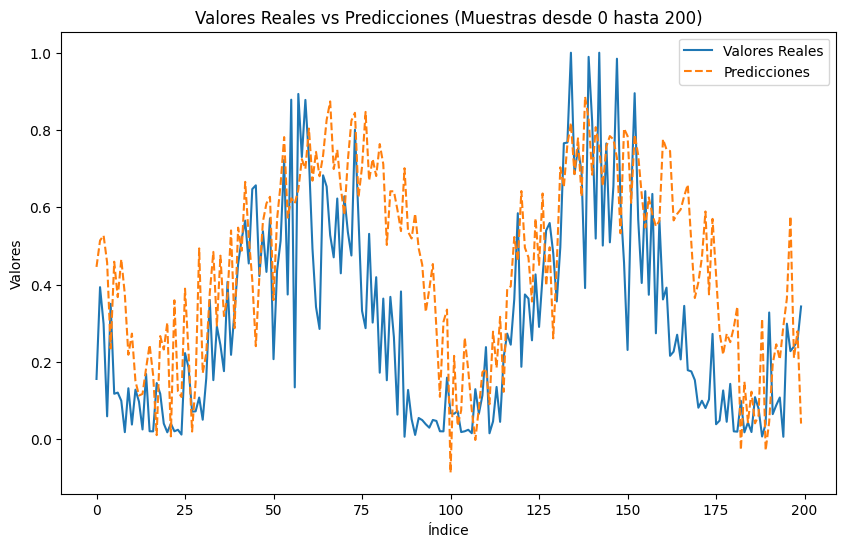

Best model saved as 'best_combined_model_optuna.h5'


In [23]:
from sklearn.model_selection import TimeSeriesSplit

# Definir el número de divisiones para TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    model, batch_size = build_combined_model(trial)
    mse_scores = []
    
    # Usar TimeSeriesSplit para la validación secuencial
    for train_index, val_index in tscv.split(X_train_images):
        X_train_img, X_val_img = X_train_images[train_index], X_train_images[val_index]
        X_train_num, X_val_num = X_train_numerical[train_index], X_train_numerical[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Entrenar el modelo en la partición actual
        history = model.fit([X_train_img, X_train_num], y_train_fold,
                            validation_data=([X_val_img, X_val_num], y_val_fold),
                            epochs=15, batch_size=batch_size, verbose=0)
        
        # Predicción en la partición de validación y cálculo del MSE
        y_val_pred = model.predict([X_val_img, X_val_num])
        
        # Verificar si la predicción contiene NaN
        if np.isnan(y_val_pred).any():
            print("Warning: y_val_pred contiene NaN. Descartando configuración.")
            return float("inf")  # Retorna un valor alto para que Optuna descarte esta configuración
        
        mse = mean_squared_error(y_val_fold, y_val_pred)
        mse_scores.append(mse)
    
    # Retornar el promedio de MSE en las particiones de validación
    return sum(mse_scores) / len(mse_scores)


# Configurar el estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())  # optimización bayesiana.
study.optimize(objective, n_trials=40)

# Obtener los mejores hiperparámetros encontrados por Optuna
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Guardar el mejor modelo
best_model, best_batch_size = build_combined_model(study.best_trial)
history = best_model.fit([X_train_images, X_train_numerical], y_train,
                         validation_data=([X_val_images, X_val_numerical], y_val),
                         epochs=15, batch_size=best_batch_size, verbose=0)

y_test_pred = best_model.predict([X_test_images, X_test_numerical])

df_resultados = pd.DataFrame({
    'Valores Reales': y_test.flatten(),
    'Predicciones': y_test_pred.flatten()
})

inicio_muestra = 0
fin_muestra = 200
graficar_rango_muestras(df_resultados, inicio_muestra, fin_muestra)

best_model.save("best_combined_model_optuna.h5")
print("Best model saved as 'best_combined_model_optuna.h5'")


In [24]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_test_pred:", y_test_pred.shape)

Shape of y_test: (1489, 1)
Shape of y_test_pred: (1489, 1)


In [25]:
import tensorflow as tf
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))



GPUs disponibles: []


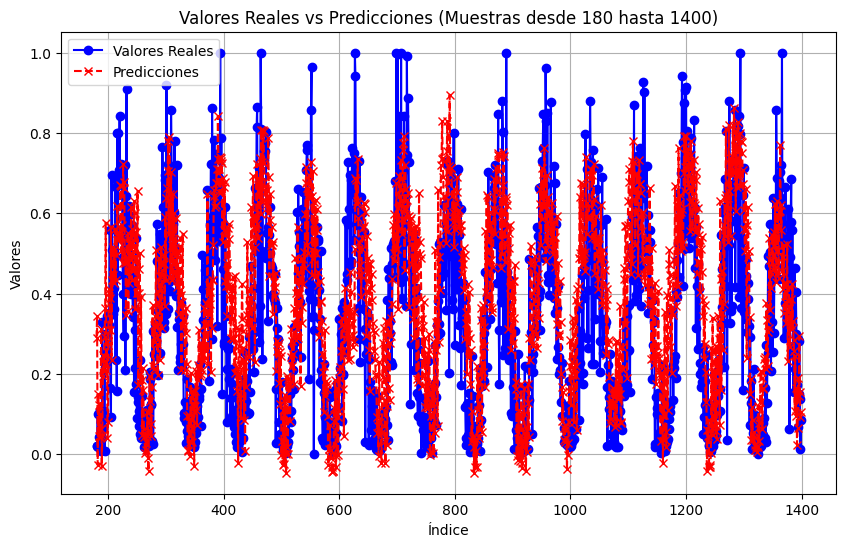

In [41]:
import matplotlib.pyplot as plt

# Graficar el rango de muestras para verificar alineación visual
def graficar_rango_muestras(df_resultados, inicio, fin):
    plt.figure(figsize=(10, 6))
    plt.plot(df_resultados['Valores Reales'][inicio:fin], label='Valores Reales', color='blue', marker='o')
    plt.plot(df_resultados['Predicciones'][inicio:fin], label='Predicciones', color='red', linestyle='--', marker='x')
    plt.title(f'Valores Reales vs Predicciones (Muestras desde {inicio} hasta {fin})')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Rango de muestra para verificar visualmente la alineación
inicio_muestra = 180
fin_muestra = 1400
graficar_rango_muestras(df_resultados, inicio_muestra, fin_muestra)


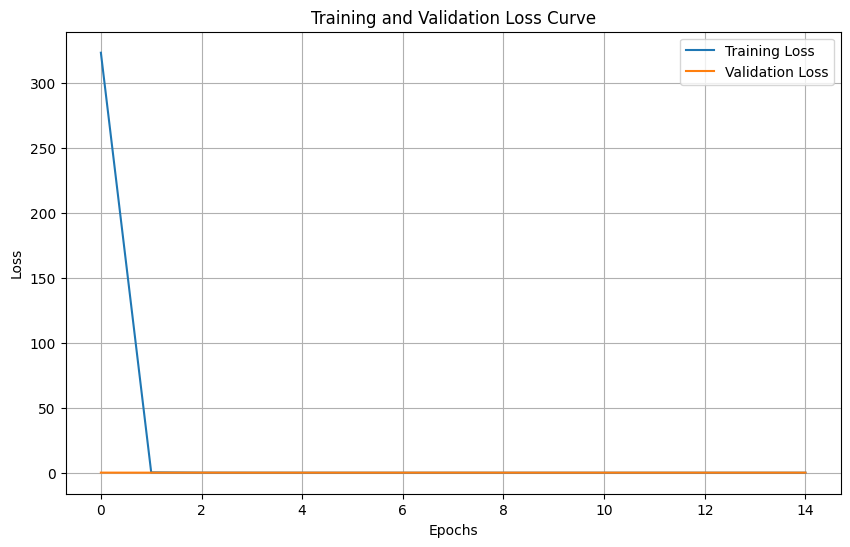

In [27]:
# Graficar curva de pérdidas
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install plotly




In [28]:

import optuna.visualization as vis



In [29]:
import plotly
import optuna.visualization as vis

# Graficar el historial de optimización
fig_optimization_history = vis.plot_optimization_history(study)
fig_optimization_history.show()

In [30]:
# Graficar la importancia de cada hiperparámetro
fig_param_importances = vis.plot_param_importances(study)
fig_param_importances.show()


In [31]:
# Graficar las coordenadas paralelas para ver las interacciones entre hiperparámetros
fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
fig_parallel_coordinate.show()


In [32]:
# Graficar el contorno de los hiperparámetros en función del valor objetivo
fig_contour = vis.plot_contour(study)
fig_contour.show()


In [33]:
y_val_pred = best_model.predict([X_val_images, X_val_numerical])

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


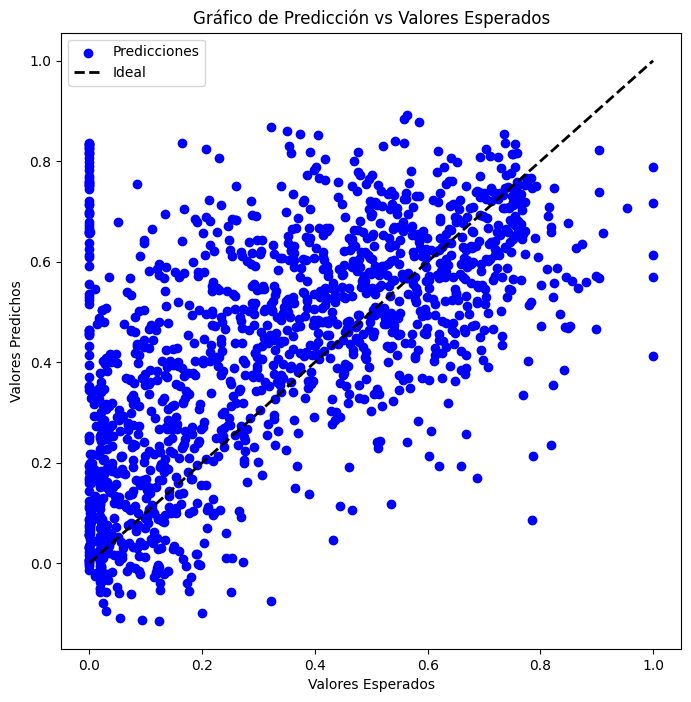

Mean Squared Error en los datos de validación: 0.055240608039249975


In [34]:
# Graficar valores esperados (y_val) vs valores predichos (y_val_pred)
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_val_pred, color='blue', label='Predicciones')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Valores Esperados')
plt.ylabel('Valores Predichos')
plt.title('Gráfico de Predicción vs Valores Esperados')
plt.legend()
plt.show()

# Calcular y mostrar el error cuadrático medio
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error en los datos de validación: {mse}")